In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download("punkt")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from google.colab import drive # Для работы с Google Drive
import time # Импортируем библиотеку time
from tensorflow.keras.callbacks import ModelCheckpoint # Для колбека
from keras.models import load_model # Для сохранения и загрузки модели
import re # Модуль работы с регулярными выражениями
import seaborn as sns # Библиотека для визуализации данных

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
train = pd.read_csv('/content/train_dataset_train.csv')
test = pd.read_csv('/content/test_dataset_test.csv')

In [3]:
train.head(10)

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория
0,2246,Помогите начальник Льговского рэс не реагирует...,"Нарушения, связанные с содержанием электросети...",Администрация Льговского района,3
1,380,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,Аварийные деревья,Администрация города Курска,3
2,2240,Агресивные собаки. На радуге там стая из подро...,Безнадзорные животные,Администрация города Курска,1
3,596,<p>На пересечении &nbsp;улиц Сосновская и Бере...,Нескошенная сорная растительность в местах общ...,Комитет дорожного хозяйства города Курска,3
4,1797,<p style=`text-align:justify;`><span style=`ba...,Аварийные деревья,Комитет городского хозяйства города Курска,3
5,1383,<p>Добрый день! Управляющая Компания “Аврора +...,Несвоевременная очистка дворовой территории мн...,Комитет жилищно-коммунального хозяйства города...,3
6,1934,"Добрый день, полностью отсутствует наружнее ос...",Неработающее наружное освещение,Администрация города Курска,3
7,2833,Едкий и вредный для здоровья запах от карьеров...,Неприятные запахи,Комитет природных ресурсов Курской области,16
8,1263,<p>Отсутствие люка</p>,Отсутствие люков на коммуникационных колодцах,Муниципальное казенное учреждение «Городская и...,3
9,1593,<p>Добрый день.&nbsp;</p><p>На остановке `Площ...,Пешеходные переходы на дорогах в границах горо...,Комитет природных ресурсов Курской области,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  2000 non-null   int64 
 1   Текст Сообщения     2000 non-null   object
 2   Тематика            2000 non-null   object
 3   Ответственное лицо  2000 non-null   object
 4   Категория           2000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 78.2+ KB


## Посмотрим на тергеты
### Тематика

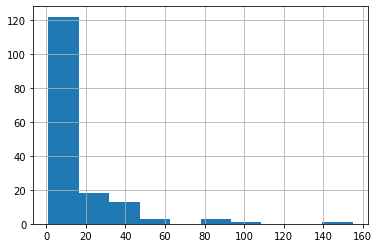

In [5]:
train["Тематика"].value_counts().hist()

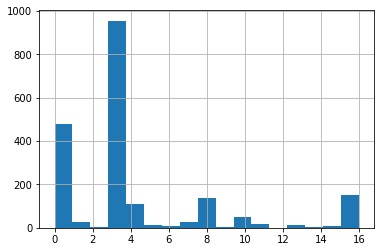

In [6]:
train["Категория"].hist(bins = 17) 

In [7]:
train["Ответственное лицо"].value_counts()

Администрация города Курска                                          421
Комитет дорожного хозяйства города Курска                            215
Комитет жилищно-коммунального хозяйства города Курска                171
Государственная жилищная инспекция Курской области                   151
Комитет городского хозяйства города Курска                           127
                                                                    ... 
МКУ «Управление по делам ГО и ЧС при Администрации города Курска»      1
Комитет агропромышленного комплекса Курской области                    1
Комитет информации и печати Курской области                            1
Администрация Кореневского района                                      1
ООО `УК `Северный дом`                                                 1
Name: Ответственное лицо, Length: 75, dtype: int64

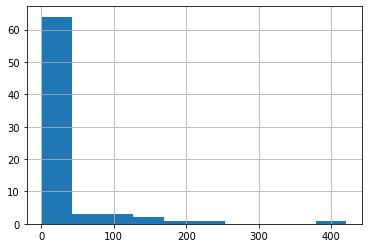

In [8]:
train["Ответственное лицо"].value_counts().hist()

## Сделаем категорию "Ответственное лицо" раноговой

In [9]:
train["Ответственное лицо"] = pd.Categorical(train["Ответственное лицо"])
train["Ответственное лицо"].astype('category').cat.codes
train["Ответственное лицо"] = train["Ответственное лицо"].cat.codes

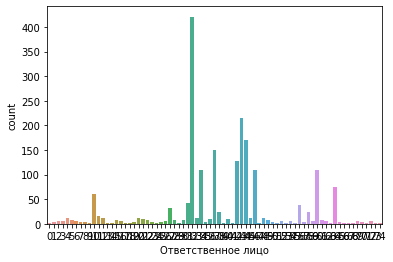

In [10]:
sns.countplot(x = "Ответственное лицо" , data  = train)

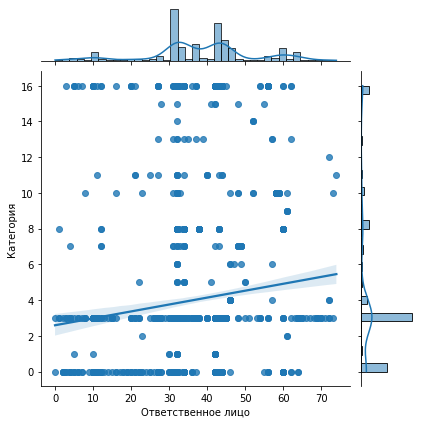

In [11]:
sns.jointplot(x = "Ответственное лицо", y = 'Категория', data = train, kind = 'reg')

Кажется нет четкой зависимости между категорией и ответственным лицом города

In [12]:
train["Тематика"] = pd.Categorical(train["Тематика"])
train["Тематика"].astype('category').cat.codes
train["Тематика"] = train["Тематика"].cat.codes

Видоизменим категорию "Тематика"

In [13]:
t = train.groupby(["Тематика", "Категория"])["id"].count().reset_index()
t['id'] = np.ones(t.shape[0])
cat_topic_links = t.pivot(columns = "Категория", index="Тематика", values="id").fillna(0)

In [14]:
train["Длина Сообщения"] = train["Текст Сообщения"].str.len()

Добавим новый столбец в датсет и взглянем на то что у нас получилось

In [15]:
train.head(3)

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория,Длина Сообщения
0,2246,Помогите начальник Льговского рэс не реагирует...,51,12,3,210
1,380,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,2,32,3,650
2,2240,Агресивные собаки. На радуге там стая из подро...,3,32,1,189


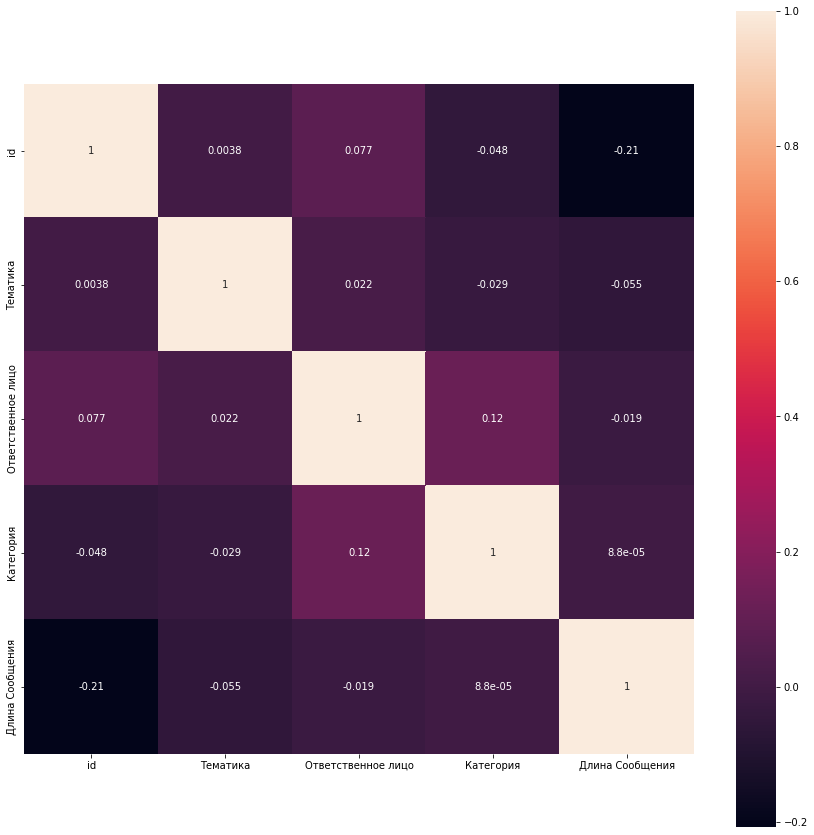

In [16]:
plt.rcParams['figure.figsize']=(15,15)

corr = train.corr()
g = sns.heatmap(corr, square = True, annot=True)

## Связь тематики и категории

In [17]:
t = train.groupby(["Тематика", "Категория"])["id"].count().reset_index()
t['id'] = np.ones(t.shape[0])
cat_topic_links = t.pivot(columns = "Категория", index="Тематика", values="id").fillna(0)

In [18]:
t.to_excel("cat_topic.xlsx")
# каждая тема отнесена к одной из категорий
(cat_topic_links.sum(axis=1)>1).mean()

0.0

In [19]:
cat_topic_links.to_excel("cat_topic_links.xlsx")
cat_topic_links

Категория,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Тематика,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
158,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Связь категории и ответственного лица

In [20]:
t2 = train.groupby(["Ответственное лицо", "Категория"])["id"].count().reset_index()
t2['id'] = np.ones(t2.shape[0])
cat_rel_links = t2.pivot(columns = "Категория", index="Ответственное лицо", values="id").fillna(0)

In [21]:
cat_rel_links.shape

(75, 17)

In [22]:
cat_rel_links.to_excel("cat_rel_links.xlsx")

In [23]:
cat_rel_links

Категория,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Ответственное лицо,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Посмотрим, какой мусор есть в сообщениях

In [24]:
train["Текст Сообщения"][10]

'Здравствуйте, в д. Старый Бузец уже 3 дня не чистят дороги от снега. Нет возможности выехать на работу. Работаю в такси, аренду автомобиля необходимо платить, а я выехать второй день не могу. Стою вот посреди дороги, застряв в снегу, под которым лёд.'

In [25]:
train.iloc[10]

id                                                                 1900
Текст Сообщения       Здравствуйте, в д. Старый Бузец уже 3 дня не ч...
Тематика                                                            138
Ответственное лицо                                                    4
Категория                                                             0
Длина Сообщения                                                     250
Name: 10, dtype: object

## Предобработка текстов
### Убираю HTML

In [26]:
import re
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
SPACER = re.compile('\s+')

def cleanhtml(raw_html):
  cleantext = re.sub(CLEANR, ' ', raw_html)
  cleantext = re.sub(SPACER, ' ', cleantext)
  return cleantext

In [27]:
train["text"] = train["Текст Сообщения"].apply(cleanhtml)

In [28]:
from string import punctuation  # Модуль для работы со строками

# Удаление символов пунктуации
def remove_punctuation(my_string):
    return "".join([ch if ch not in punctuation else ' ' for ch in my_string]) # Замена на пробелы!!!

# Удаление чисел
def remove_numbers(my_string):
    return ''.join([i if not i.isdigit() else ' ' for i in my_string])

# Замена множественных пробелов на одинарный пробел
import re
def remove_multiple_spaces(my_string):
	return re.sub(r'\s+', ' ', my_string, flags=re.I)

# Обработка строк + дополнительно приведение к нижнему регистру
preproccessing = lambda text: (remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower())))) 

# Создаем колонку в датасете для обработанного текста
train['text_processed'] = list(map(preproccessing, train['text']))
train.head()

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория,Длина Сообщения,text,text_processed
0,2246,Помогите начальник Льговского рэс не реагирует...,51,12,3,210,Помогите начальник Льговского рэс не реагирует...,помогите начальник льговского рэс не реагирует...
1,380,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,2,32,3,650,По фасаду дома по адресу ул. Урицкого 22 прох...,по фасаду дома по адресу ул урицкого проходит...
2,2240,Агресивные собаки. На радуге там стая из подро...,3,32,1,189,Агресивные собаки. На радуге там стая из подро...,агресивные собаки на радуге там стая из подрос...
3,596,<p>На пересечении &nbsp;улиц Сосновская и Бере...,90,43,3,302,На пересечении улиц Сосновская и Береговая за...,на пересечении улиц сосновская и береговая за...
4,1797,<p style=`text-align:justify;`><span style=`ba...,2,42,3,666,Здравствуйте! Рядом с домом 1 «А» по улице Св...,здравствуйте рядом с домом «а» по улице светл...


## Steamming

In [29]:
# NLTK - библиотек Python для решения задач обработки естественного языка
import nltk

from nltk.stem.snowball import SnowballStemmer    # Стеммер Porter2 - новая версия стеммера Портера
from nltk.corpus import stopwords                 # Библиотека стоп-слов
from nltk import word_tokenize                    # Токенизатор

nltk.download('stopwords')                        # Загрузка стоп-слов
nltk.download('punkt')                            # Загрузка символов пунктуации
stemmer = SnowballStemmer("russian")              # Стеммер для русского языка

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
russian_stopwords = stopwords.words("russian")    # Список стоп-слов для русского языка
# Расширение списка стоп-слов (см. набор данных)
russian_stopwords.extend(['…', '«', '»', '...', 'т.д.', 'т', 'д', 'nan'])

In [31]:
# Провердим стемминг и избавляемся от стоп-слов
from tqdm.auto import tqdm, trange
stemmed_text_column = []
for text in tqdm(train['text_processed']):
    tokens = word_tokenize(text)    
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
    text = " ".join(stemmed_tokens)
    stemmed_text_column.append(text)

# Создаем новую колонку в наборе данных
train['text_stemmed'] = stemmed_text_column
train['text_stemmed'][0]

  0%|          | 0/2000 [00:00<?, ?it/s]

'помог начальник льговск рэс реагир жалоб мал ветер сид свет имен деревн больш угон улиц стар слобод пожалуйст помог пуска вычист фотоотчет сдела'

In [32]:
train.head()

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория,Длина Сообщения,text,text_processed,text_stemmed
0,2246,Помогите начальник Льговского рэс не реагирует...,51,12,3,210,Помогите начальник Льговского рэс не реагирует...,помогите начальник льговского рэс не реагирует...,помог начальник льговск рэс реагир жалоб мал в...
1,380,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,2,32,3,650,По фасаду дома по адресу ул. Урицкого 22 прох...,по фасаду дома по адресу ул урицкого проходит...,фасад дом адрес ул урицк проход труб газов маг...
2,2240,Агресивные собаки. На радуге там стая из подро...,3,32,1,189,Агресивные собаки. На радуге там стая из подро...,агресивные собаки на радуге там стая из подрос...,агресивн собак радуг ста подросш щенк звросл с...
3,596,<p>На пересечении &nbsp;улиц Сосновская и Бере...,90,43,3,302,На пересечении улиц Сосновская и Береговая за...,на пересечении улиц сосновская и береговая за...,пересечен улиц сосновск берегов завал песк гра...
4,1797,<p style=`text-align:justify;`><span style=`ba...,2,42,3,666,Здравствуйте! Рядом с домом 1 «А» по улице Св...,здравствуйте рядом с домом «а» по улице светл...,здравств ряд дом улиц светл вне придомов терри...


## Лемматизация

In [33]:
!pip install pymorphy2            # pymorphy2 - морфологический анализатор для русского языка
!pip install pymorphy2-dicts      # пакет со словарями
!pip install DAWG-Python          


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.4 MB/s 
     |████████████████████████████████| 8.2 MB 7.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.1 MB 4.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [35]:
morph.parse('шел')[0].normal_form  # Получение нулевой формы слова

'идти'

In [36]:
# Провердим лемматизацию и избавляемся от стоп-слов
lemm_texts_column = []
for text in tqdm(train['text_processed']):
    tokens = word_tokenize(text)    
    lemmed_tokens = [morph.parse(token)[0].normal_form for token in tokens if token not in russian_stopwords]
    text = " ".join(lemmed_tokens)
    lemm_texts_column.append(text)
    
# Создаем новую колонку в наборе данных
train['text_lemmed'] = lemm_texts_column

train['text_lemmed'][0]

  0%|          | 0/2000 [00:00<?, ?it/s]

'помочь начальник льговский рэс реагировать жалоба малый ветер сидеть свет именно деревня больший угон улица старый слобода пожалуйста помочь пускай вычистить фотоотчёт сделать'

In [37]:
train.head()

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория,Длина Сообщения,text,text_processed,text_stemmed,text_lemmed
0,2246,Помогите начальник Льговского рэс не реагирует...,51,12,3,210,Помогите начальник Льговского рэс не реагирует...,помогите начальник льговского рэс не реагирует...,помог начальник льговск рэс реагир жалоб мал в...,помочь начальник льговский рэс реагировать жал...
1,380,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,2,32,3,650,По фасаду дома по адресу ул. Урицкого 22 прох...,по фасаду дома по адресу ул урицкого проходит...,фасад дом адрес ул урицк проход труб газов маг...,фасад дом адрес ул урицкий проходить труба газ...
2,2240,Агресивные собаки. На радуге там стая из подро...,3,32,1,189,Агресивные собаки. На радуге там стая из подро...,агресивные собаки на радуге там стая из подрос...,агресивн собак радуг ста подросш щенк звросл с...,агресивный собака радуга стая подрасти щенок з...
3,596,<p>На пересечении &nbsp;улиц Сосновская и Бере...,90,43,3,302,На пересечении улиц Сосновская и Береговая за...,на пересечении улиц сосновская и береговая за...,пересечен улиц сосновск берегов завал песк гра...,пересечение улица сосновский береговой завалит...
4,1797,<p style=`text-align:justify;`><span style=`ba...,2,42,3,666,Здравствуйте! Рядом с домом 1 «А» по улице Св...,здравствуйте рядом с домом «а» по улице светл...,здравств ряд дом улиц светл вне придомов терри...,здравствуйте рядом дом улица светлый вне придо...


## Токенизация

In [38]:
# from nltk import word_tokenize

word_tokenize(train['text_lemmed'][0])

['помочь',
 'начальник',
 'льговский',
 'рэс',
 'реагировать',
 'жалоба',
 'малый',
 'ветер',
 'сидеть',
 'свет',
 'именно',
 'деревня',
 'больший',
 'угон',
 'улица',
 'старый',
 'слобода',
 'пожалуйста',
 'помочь',
 'пускай',
 'вычистить',
 'фотоотчёт',
 'сделать']

## Мешок слов

In [39]:
# CountVectorizer - класс конвертации текста в матрицу токенов
from sklearn.feature_extraction.text import CountVectorizer

In [40]:
# Создание матрицы признаков на основе мешка слов
count = CountVectorizer()
bag_of_words = count.fit_transform(train['text_lemmed'])
bag_of_words.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [41]:
count.get_feature_names_out()

array(['ammann', 'baw', 'be', ..., 'ёж', 'ёлка', 'ёлочка'], dtype=object)

In [42]:
# Создание матрицы признаков для 2-грамм
count_2gram = CountVectorizer(ngram_range=(2,2))
bag_of_2grams = count_2gram.fit_transform(train['text_lemmed'])
bag_of_2grams.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [43]:
count_2gram.get_feature_names_out()  # Вывод имен признаков

array(['ammann пос', 'baw street', 'be kxgp', ..., 'ёлка новый',
       'ёлка озеленить', 'ёлочка надеяться'], dtype=object)

## Взвешивание важности слов - TF-IDF

In [44]:
# TfidfVectorizer - класс для преобразования текста в частотные векторы слов
from sklearn.feature_extraction.text import TfidfVectorizer

In [45]:
# Создание матрицы признаков
from sklearn.feature_extraction.text import TfidfVectorizer
td = TfidfVectorizer(max_features = 4500)
#X = td.fit_transform(X).toarray()

## Нормализуем датасет для обучения нейронной сети

In [46]:
texts = train['Текст Сообщения'].values # Извлекаем данные всех текстов из столбца 'Текст Сообщения'
classes = list(train['Категория'].values) # Извлекаем соответствующие им значения классов (лейблов) столбца 'Текст Сообщения'
maxWordsCount = 9000 # Зададим максимальное количество слов/индексов, учитываемое при обучении текстов

print(train['Категория'].unique()) # Выводим все уникальные значения классов
nClasses = train['Категория'].nunique() # Задаём количество классов, обращаясь к столбцу 'Категория' и оставляя уникальные значения
print('Количество классов =', nClasses) # Посмотрим на количество классов

[ 3  1 16  0  6  8  4 13 10 11 14  7  5 15  2  9 12]
Количество классов = 17


In [47]:
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#Для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
#num_words=maxWordsCount - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
#lower=True - приводим слова к нижнему регистру
#split=' ' - разделяем слова по пробелу
#char_level=False - просим токенайзер не удалять однобуквенные слова
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)#False

tokenizer.fit_on_texts(texts) # Даём в обработку наши тексты, методу, который соберет словарь частотности

# Формируем матрицу индексов по принципу Bag of Words
xAll = tokenizer.texts_to_matrix(texts) # Каждое слово из текста нашло свой индекс в векторе длиной maxWordsCount и отметилось в нем единичкой 
print(xAll.shape)  # Посмотрим на форму текстов
print(xAll[0, :20])# И отдельно на фрагмент начала вектора

(2000, 9000)
[0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]


In [48]:
# Посмотрим размер словаря
print("Размер словаря", len(tokenizer.word_index.items()))

Размер словаря 18519


In [49]:
#Преобразовываем категории в векторы
encoder = LabelEncoder() # Вызываем метод кодирования тестовых лейблов из библиотеки sklearn
encoder.fit(classes) # Подгружаем в него категории из нашей базы
classesEncoded = encoder.transform(classes) # Кодируем категории
print('Посмотрим кодированные категории', encoder.classes_) # Посмотрим кодированные категории
print('Количество',classesEncoded.shape)
print('Посмотрим как выглядят первые 17 категорий', classesEncoded[:17])

yAll = utils.to_categorical(classesEncoded, nClasses) # И выводим каждый лейбл в виде вектора длиной 17, с 1кой в позиции соответствующего класса и нулями
print('Форма лейблов', yAll.shape) # Посмотрим на форму лейблов категорий
print('Первая строка лейблов',yAll[0]) # И отдельно на первую строку

Посмотрим кодированные категории [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Количество (2000,)
Посмотрим как выглядят первые 17 категорий [ 3  3  1  3  3  3  3 16  3  0  0  3  3  3  0  3  3]
Форма лейблов (2000, 17)
Первая строка лейблов [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [50]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size=0.2, shuffle = True) # Берем 20% на тестовую выборку и перемешиваем данные
print(xTrain.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain.shape) #и на форму соответсвующих им классов

(1600, 9000)
(1600, 17)


## Сохранение весов модели для выбора наилучшей эпохи

In [51]:
# Сохраняем сеть на каждой эпохе
# {epoch:02d} - номер эпохи
# {val_acc:.4f} - значение аккуратности на проверочном ноборе данных
callbacks = [ModelCheckpoint('save_models/Appeals_of_citizens-{epoch:02d}-{loss:.4f}.hdf5')]
# Сохраняем только лучший вариант сети
#callbacks = [ModelCheckpoint('save/Kursk-text.hdf5', monitor='val_loss', save_best_only=True)]

## Обучаем нейронную сеть

Epoch 1/100
25/25 - 1s - loss: 2.4540 - accuracy: 0.3587 - val_loss: 1.8544 - val_accuracy: 0.4700 - 1s/epoch - 51ms/step
Epoch 2/100
25/25 - 0s - loss: 1.7606 - accuracy: 0.4856 - val_loss: 1.4342 - val_accuracy: 0.4925 - 406ms/epoch - 16ms/step
Epoch 3/100
25/25 - 0s - loss: 1.2500 - accuracy: 0.6037 - val_loss: 1.0775 - val_accuracy: 0.6275 - 412ms/epoch - 16ms/step
Epoch 4/100
25/25 - 0s - loss: 0.8535 - accuracy: 0.7325 - val_loss: 0.9379 - val_accuracy: 0.7125 - 398ms/epoch - 16ms/step
Epoch 5/100
25/25 - 0s - loss: 0.6023 - accuracy: 0.8181 - val_loss: 0.9251 - val_accuracy: 0.7425 - 381ms/epoch - 15ms/step
Epoch 6/100
25/25 - 0s - loss: 0.4090 - accuracy: 0.8756 - val_loss: 0.9288 - val_accuracy: 0.7550 - 428ms/epoch - 17ms/step
Epoch 7/100
25/25 - 0s - loss: 0.3184 - accuracy: 0.9137 - val_loss: 1.0534 - val_accuracy: 0.7475 - 402ms/epoch - 16ms/step
Epoch 8/100
25/25 - 0s - loss: 0.2415 - accuracy: 0.9319 - val_loss: 1.0493 - val_accuracy: 0.7650 - 403ms/epoch - 16ms/step
Epo

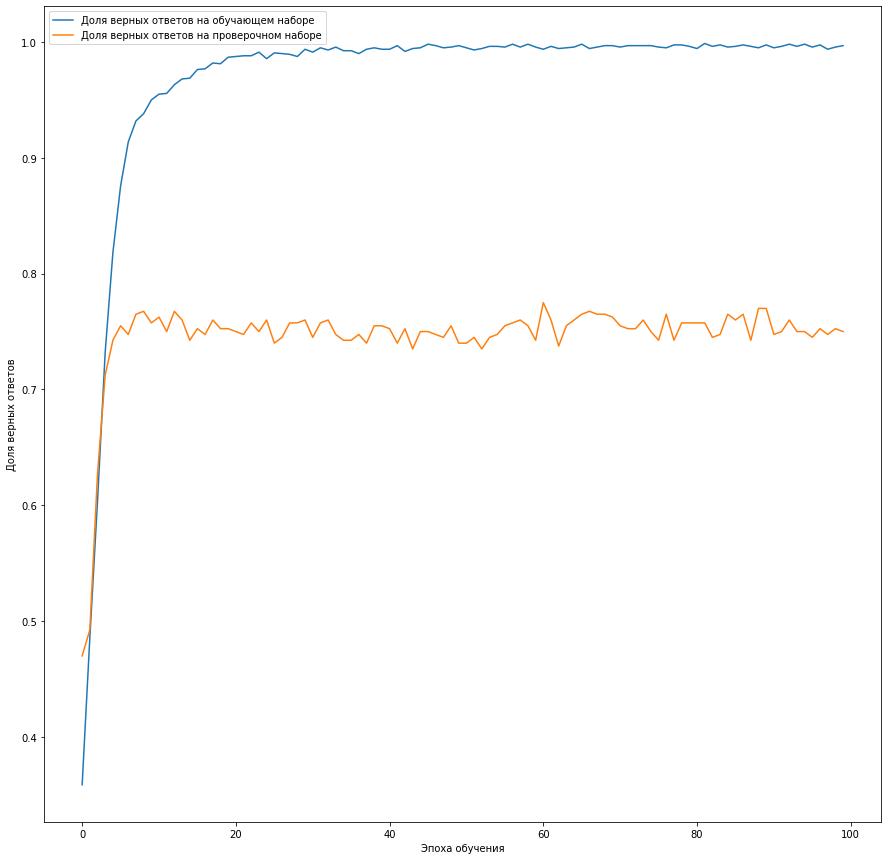

In [53]:
#Создаём полносвязную сеть
model = Sequential()
#Входной полносвязный слой
model.add(Dense(100, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.2)) 
#Второй полносвязный слой
model.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model.add(Dropout(0.3))
#Третий полносвязный слой
model.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model.add(Dropout(0.4))
#Выходной полносвязный слой
model.add(Dense(nClasses, activation='softmax'))#softmax, sigmoid
time_start = [time.time()]

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=64,
                    validation_data=(xVal, yVal),
                    verbose=2,
                    callbacks=callbacks)

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
# 82 эпоха оказалась лучшей
# Загружаем эпоху из дериктории
#model = load_model('/content/save_models/Appeals_of_citizens-82-0.9987.hdf5')
# Перезаписываем на диск
model.save('/content/Appeals_of_citizens-82-v_ac_0.9987.hdf5')

## Тестовый датасет

## Выполним предобработку тестового датасета

In [54]:
# Удаляем не нужные колоки 
test.drop(test.columns[[2,3]], axis=1, inplace=True)
test.head(3) # Смотрим

,id,Текст Сообщения
0,843,<p>Здравствуйте. На улице Мира &nbsp;было заме...
1,1422,<p>Уже вторую неделю не горит уличное освещени...
2,2782,Не работает освещение во дворе дома 11а по Эне...


In [55]:
import re
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
SPACER = re.compile('\s+')

def cleanhtml(raw_html):
  cleantext = re.sub(CLEANR, ' ', raw_html)
  cleantext = re.sub(SPACER, ' ', cleantext)
  return cleantext


In [56]:
test["text"] = test["Текст Сообщения"].apply(cleanhtml)

In [57]:
from string import punctuation  # Модуль для работы со строками

# Удаление символов пунктуации
def remove_punctuation(my_string):
    return "".join([ch if ch not in punctuation else ' ' for ch in my_string]) # Замена на пробелы!!!

# Удаление чисел
def remove_numbers(my_string):
    return ''.join([i if not i.isdigit() else ' ' for i in my_string])

# Замена множественных пробелов на одинарный пробел
import re
def remove_multiple_spaces(my_string):
    return re.sub(r'\s+', ' ', my_string, flags=re.I)

# Обработка строк + дополнительно приведение к нижнему регистру
preproccessing = lambda text: (remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower())))) 

# Создаем колонку в датасете для обработанного текста
test['text_processed'] = list(map(preproccessing, test['text']))
test.head()

,id,Текст Сообщения,text,text_processed
0,843,<p>Здравствуйте. На улице Мира &nbsp;было заме...,Здравствуйте. На улице Мира было заменено нар...,здравствуйте на улице мира было заменено нару...
1,1422,<p>Уже вторую неделю не горит уличное освещени...,Уже вторую неделю не горит уличное освещение,уже вторую неделю не горит уличное освещение
2,2782,Не работает освещение во дворе дома 11а по Эне...,Не работает освещение во дворе дома 11а по Эне...,не работает освещение во дворе дома а по энерг...
3,2704,После покоса сорной растительности на газоне м...,После покоса сорной растительности на газоне м...,после покоса сорной растительности на газоне м...
4,1,<p>Прошу принять меры к водителю маршрута 263:...,Прошу принять меры к водителю маршрута 263: п...,прошу принять меры к водителю маршрута пос се...


In [58]:
morph.parse('шел')[0].normal_form  # Получение нулевой формы слова

'идти'

In [59]:
lemm_texts_column = []
for text in tqdm(test['text_processed']):
    tokens = word_tokenize(text)    
    lemmed_tokens = [morph.parse(token)[0].normal_form for token in tokens if token not in russian_stopwords]
    text = " ".join(lemmed_tokens)
    lemm_texts_column.append(text)
    
# Создаем новую колонку в наборе данных
test['text_lemmed'] = lemm_texts_column

test['text_lemmed'][0]

  0%|          | 0/1000 [00:00<?, ?it/s]

'здравствуйте улица мир заменить наружное освещение именно заменить лампа энергосберегающий лампа протяжение несколько месяц освещение улица отсутствовать последний улица осветить это зима приблизительно каждый день человек работать часовой смена многие возвращаться очень поздно дать проблема улица посёлок'

## Определим категорию текста обращения и выведем её в новый столбец

In [60]:
test.head (3)

,id,Текст Сообщения,text,text_processed,text_lemmed
0,843,<p>Здравствуйте. На улице Мира &nbsp;было заме...,Здравствуйте. На улице Мира было заменено нар...,здравствуйте на улице мира было заменено нару...,здравствуйте улица мир заменить наружное освещ...
1,1422,<p>Уже вторую неделю не горит уличное освещени...,Уже вторую неделю не горит уличное освещение,уже вторую неделю не горит уличное освещение,второй неделя гореть уличный освещение
2,2782,Не работает освещение во дворе дома 11а по Эне...,Не работает освещение во дворе дома 11а по Эне...,не работает освещение во дворе дома а по энерг...,работать освещение двор дом энергетик световой...


In [61]:
# Удаляем не нужные колоки 
test.drop(test.columns[[1,2,4]], axis=1, inplace=True)
test.head(3) # Смотрим

,id,text_processed
0,843,здравствуйте на улице мира было заменено нару...
1,1422,уже вторую неделю не горит уличное освещение
2,2782,не работает освещение во дворе дома а по энерг...


In [64]:
test.rename(columns={
    'text_processed': 'Текст Сообщения'    
}, inplace=True)
test.head(3) # Смотрим

,id,Текст Сообщения
0,843,здравствуйте на улице мира было заменено нару...
1,1422,уже вторую неделю не горит уличное освещение
2,2782,не работает освещение во дворе дома а по энерг...


In [65]:
test_mess = np.array(test['Текст Сообщения']) # Переводим сообщения в массив
x = tokenizer.texts_to_matrix(test_mess) # Токенизируем массив

prediction = model.predict(x)

for i in range(len(x)): # Циклом проходимся по токенизированному массиву
  test.loc[i,'Категория'] = np.argmax(prediction[i]) # Присваеваем категорию каждому обращению 
test = test.astype({'Категория':'Int64'}) # Переводим цифры в целочисленный формат
test # Смотрим что получилось

,id,Текст Сообщения,Категория
0,843,здравствуйте на улице мира было заменено нару...,0
1,1422,уже вторую неделю не горит уличное освещение,3
2,2782,не работает освещение во дворе дома а по энерг...,3
3,2704,после покоса сорной растительности на газоне м...,3
4,1,прошу принять меры к водителю маршрута пос се...,8
...,...,...,...
995,2619,добрый день я и моя семья жители пос волокно м...,16
996,2518,на лазарева г щигры ветка тополя скоро выбьет ...,3
997,2524,перед входом комитет образования курска ямы на...,0
998,1577,доброго времени суток у меня на пол года был ...,4


## Приводим тестовый набор к формату для сдачи 